In [1]:
# pip install langgraph

In [2]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [3]:
@tool
def recommend_recipe(dish):
    """주어진 요리에 대한 간단한 레시피를 제공합니다."""
    recipes = {
        "파스타" : "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘, 면을 삶고 소스를 부어주세요",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요."
    }
    return recipes.get(dish, '죄송하지만 해당 요리의 레시피를 찾을 수 없습니다.')

In [4]:
tools = [recommend_recipe]
tool_node = ToolNode(tools)
model = ChatOpenAI(model = 'gpt-4o-mini', temperature=0).bind_tools(tools)

In [5]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    return END

def call_model(state: MessagesState):
    message = state['messages']
    response = model.invoke(message)
    return {'messages' : [response]}

In [6]:
workflow = StateGraph(MessagesState)
workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)

workflow.set_entry_point('agent')
workflow.add_conditional_edges('agent', should_continue)
workflow.add_edge('tools', 'agent')

checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

final_state = app.invoke(
    {'messages' : [HumanMessage(content="불고기 레시피 알려줘")]},
    config={'configurable' : {'thread_id' : 100}}
)

In [7]:
final_state['messages'][-1].content

'불고기 레시피는 다음과 같습니다:\n\n### 재료\n- 소고기\n- 간장\n- 설탕\n- 마늘\n\n### 조리 방법\n1. 소고기를 얇게 썰어주세요.\n2. 간장, 설탕, 다진 마늘을 섞어 양념장을 만듭니다.\n3. 썰어놓은 소고기를 양념장에 재워 30분 정도 둡니다.\n4. 팬에 기름을 두르고 재운 소고기를 볶아주세요.\n5. 고기가 익으면 접시에 담아 맛있게 즐기세요!\n\n맛있게 드세요!'

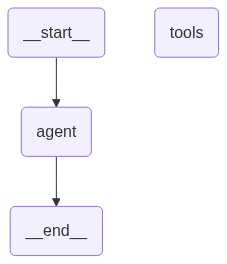

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))